In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('processed/442100110323_hourly.csv')
df

,READ_DATE,KWH_EXP
0,2019-01-01 00:00:00,2.402650
1,2019-01-01 01:00:00,2.408348
2,2019-01-01 02:00:00,2.406840
3,2019-01-01 03:00:00,2.256511
4,2019-01-01 04:00:00,2.065598
...,...,...
47467,2024-05-31 19:00:00,65.205495
47468,2024-05-31 20:00:00,65.520523
47469,2024-05-31 21:00:00,66.389436
47470,2024-05-31 22:00:00,69.132420


### Exploratory Data Analysis

In [3]:
# ADF test
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['KWH_EXP'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -2.341408
p-value: 0.158960
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


Berdasarkan hasil ADF test, p-value (0.158960) lebih besar dari 0.05 dan ADF Statistic (-2.341408) lebih besar dari critical value pada tingkat signifikansi 5% (-2.862). Ini berarti kita gagal menolak hipotesis nol, sehingga time series df['KWH_EXP'] kemungkinan besar tidak stasioner.

In [4]:
# KPSS test
from statsmodels.tsa.stattools import kpss

result = kpss(df['KWH_EXP'])
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))


KPSS Statistic: 0.484825
p-value: 0.045084
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


Berdasarkan hasil KPSS test, p-value (0.045084) lebih kecil dari 0.05 dan KPSS Statistic (0.484825) lebih besar dari critical value pada tingkat signifikansi 5% (0.463). Ini berarti kita menolak hipotesis nol, sehingga time series df['KWH_EXP'] kemungkinan besar tidak stasioner.

Dukungan visualisasi untuk melihat ketidak stasioneran data

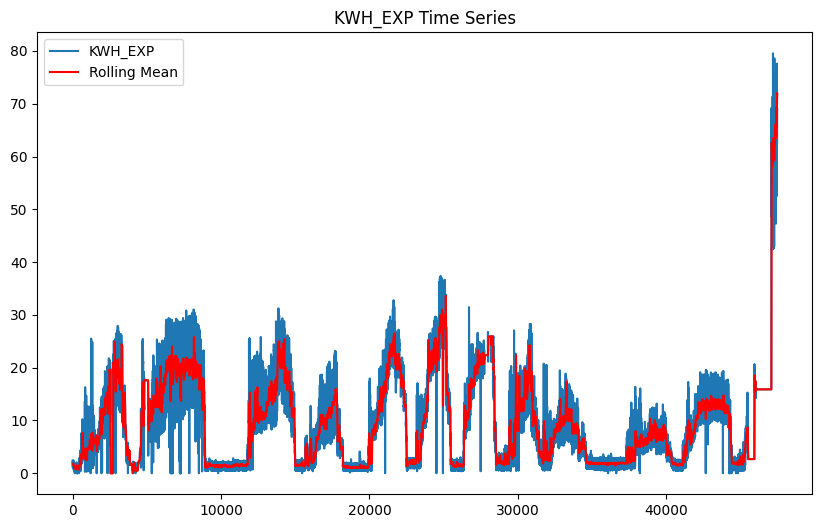

In [5]:
# simple moving avarage untuk identifikasi trend dan seasonality
rolling_mean = df['KWH_EXP'].rolling(window=24).mean()

plt.figure(figsize=(10, 6))
plt.plot(df['KWH_EXP'], label='KWH_EXP')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.legend(loc='best')
plt.title('KWH_EXP Time Series')
plt.show()


Cek tren di timeframe yang lebih tinggi supaya lebih terlihat

Text(0.5, 1.0, 'KWH_EXP Weekly Time Series')

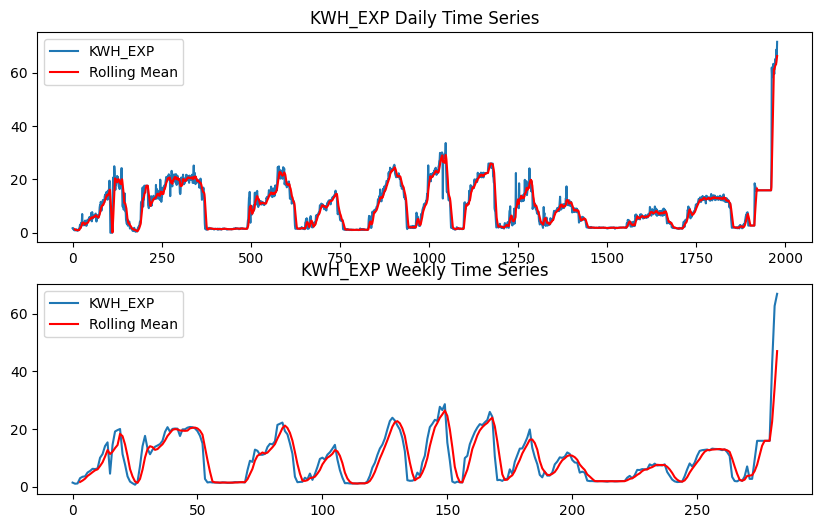

In [6]:
df_daily = pd.read_csv('processed/442100110323_daily.csv')
df_weekly = pd.read_csv('processed/442100110323_weekly.csv')

rolling_mean_daily = df_daily['KWH_EXP'].rolling(window=7).mean()
rolling_mean_week = df_weekly['KWH_EXP'].rolling(window=4).mean()

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(df_daily['KWH_EXP'], label='KWH_EXP')
ax[0].plot(rolling_mean_daily, label='Rolling Mean', color='red')
ax[0].legend(loc='best')
ax[0].set_title('KWH_EXP Daily Time Series')

ax[1].plot(df_weekly['KWH_EXP'], label='KWH_EXP')
ax[1].plot(rolling_mean_week, label='Rolling Mean', color='red')
ax[1].legend(loc='best')
ax[1].set_title('KWH_EXP Weekly Time Series')


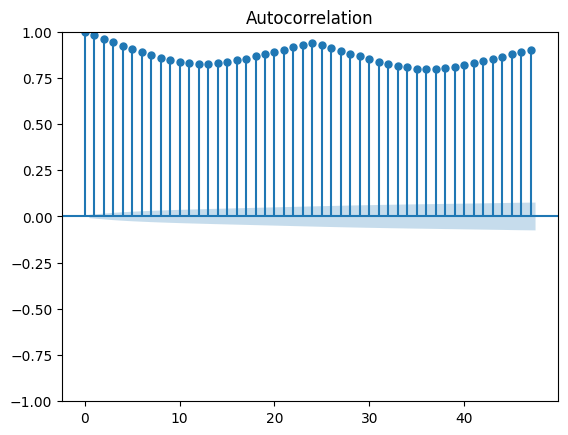

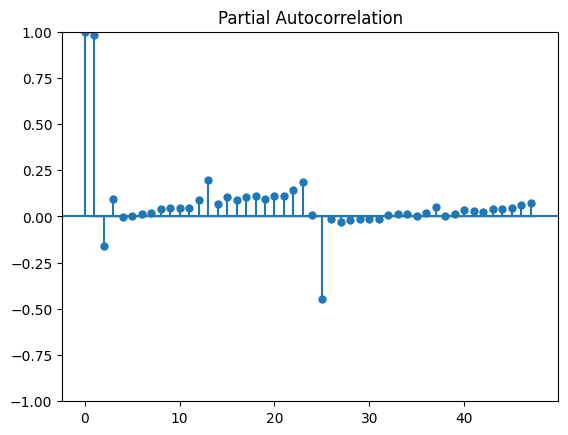

In [7]:
# plot acf dan pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['KWH_EXP'])
plt.show()
plot_pacf(df['KWH_EXP'])
plt.show()

* Pola ACF tidak mengalami penurunan / decay yang signifikan, termasuk ciri-ciri stasioner. 
* Pola bergelombang pada ACF juga menunjukkan adanya komponen musiman pada data
* Terdapat lag yang signifikan di titik 1 dan 2 pada plot PACF

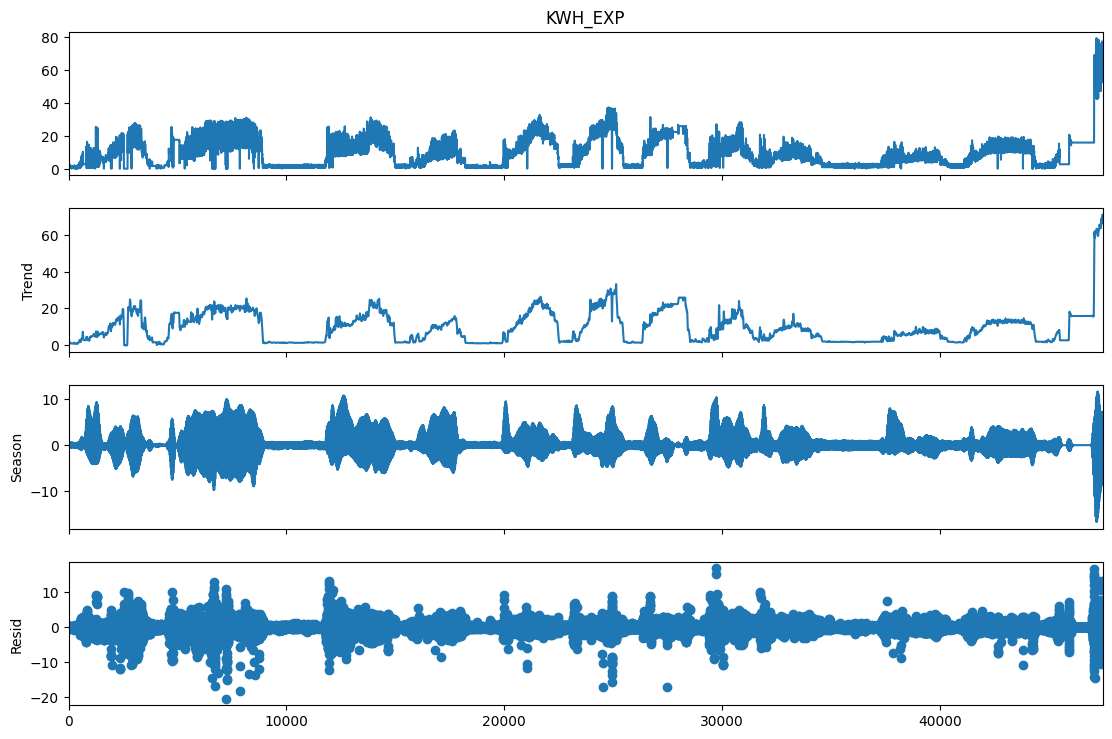

In [8]:
# Seasonal and Trend decomposition using LOESS (STL)
from statsmodels.tsa.seasonal import STL

stl = STL(df['KWH_EXP'], seasonal=13, period=24) 
res = stl.fit()

fig = res.plot()
fig.set_size_inches(12, 8)
plt.show()


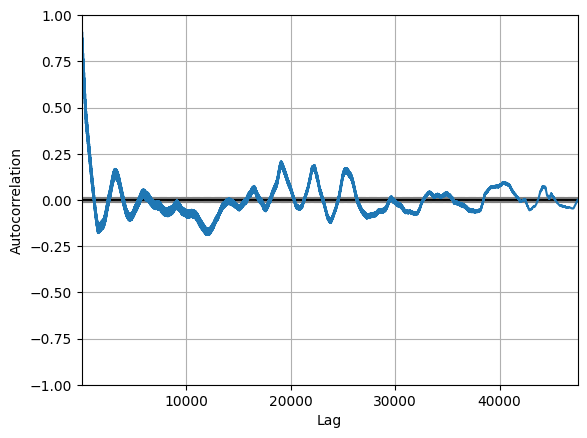

In [9]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['KWH_EXP'])
plt.show()

### Data Preprocessing after EDA

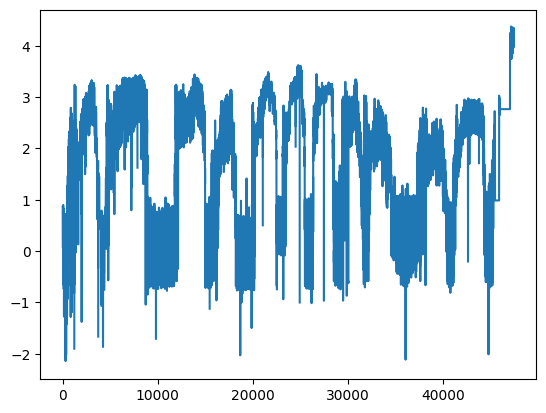

In [10]:
# logaritmic transformation
import numpy as np

df['KWH_EXP_log'] = np.log(df['KWH_EXP'])
plt.plot(df['KWH_EXP_log'])
plt.show()

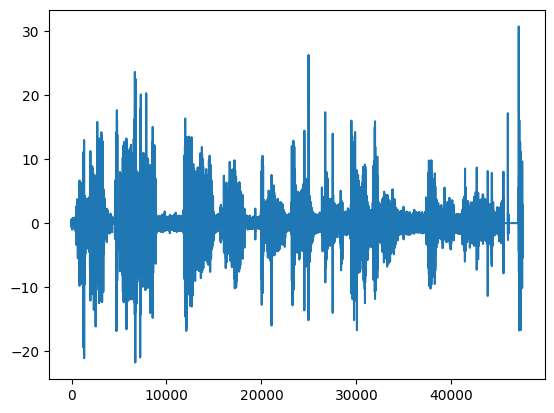

In [11]:
# differencing
df['KWH_EXP_diff'] = df['KWH_EXP'] - df['KWH_EXP'].shift()
plt.plot(df['KWH_EXP_diff'])
plt.show()

In [12]:
df[df['KWH_EXP_diff'].isna()]

,READ_DATE,KWH_EXP,KWH_EXP_log,KWH_EXP_diff
0,2019-01-01 00:00:00,2.40265,0.876572,NaN


In [13]:
df['KWH_EXP_diff'].fillna(df['KWH_EXP_diff'].mean(), inplace=True)

In [14]:
df['KWH_EXP_diff'][0]

0.0014032408342423575

In [15]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    print ('Results of Dickey-Fuller Test:')
    
    #Perform Dickey-Fuller test:
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

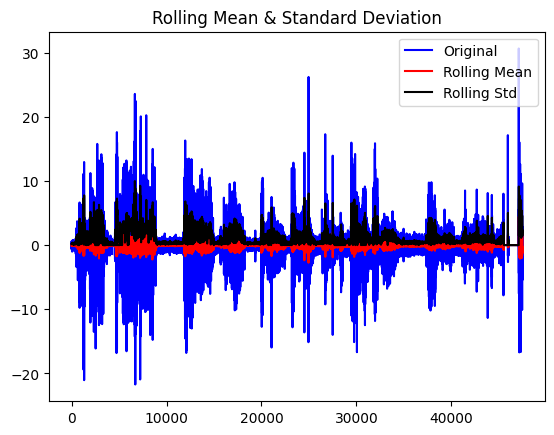

Results of Dickey-Fuller Test:
Test Statistic                   -32.258236
p-value                            0.000000
#Lags Used                        57.000000
Number of Observations Used    47414.000000
Critical Value (1%)               -3.430488
Critical Value (5%)               -2.861601
Critical Value (10%)              -2.566802
dtype: float64


In [16]:
test_stationarity(df['KWH_EXP_diff'])

Berdasarkan hasil ADF test, p-value (0.000000) lebih kecil dari 0.05 dan Test Statistic (-32.258236) lebih kecil dari nilai kritis pada tingkat signifikansi 1% (-3.430488). Ini berarti kita menolak hipotesis nol, sehingga time series df['KWH_EXP_diff'] kemungkinan besar stasioner.

In [17]:
# buat df dari data yang sudah di differencing dan read date
df_diff = df[['READ_DATE', 'KWH_EXP_diff']]
df_diff.to_csv('processed/442100110323_hourly_stationary.csv', index=False)

### DIFFERENCING RAW DATA

In [18]:
df = pd.read_csv('processed/442100110323_standard.csv')

# differencing
df['KWH_EXP_diff'] = df['KWH_EXP'] - df['KWH_EXP'].shift()
df['KWH_EXP_diff'].fillna(df['KWH_EXP_diff'].mean(), inplace=True)

df_diff_15 = df[['READ_DATE', 'KWH_EXP_diff']]
df_diff_15.to_csv('processed/442100110323_15min_stationary.csv', index=False)

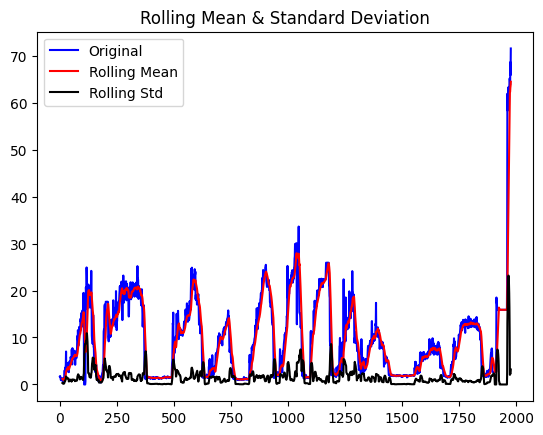

Results of Dickey-Fuller Test:
Test Statistic                   -2.862144
p-value                           0.049931
#Lags Used                       14.000000
Number of Observations Used    1963.000000
Critical Value (1%)              -3.433686
Critical Value (5%)              -2.863013
Critical Value (10%)             -2.567554
dtype: float64


In [19]:
df = pd.read_csv('processed/442100110323_daily.csv')

test_stationarity(df['KWH_EXP'])

Timeframe daily sudah stationary

### EDA for Stationary Data

Jika memang dibutuhkan menggunakan data yang telah stasioner ini, bisa melihat komponen-komponen dari data hasil differencing

<Axes: >

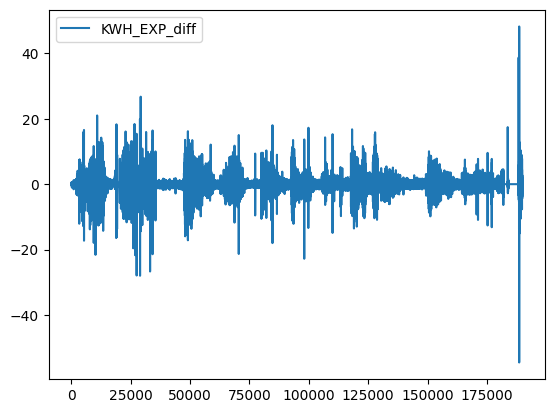

In [20]:
df = pd.read_csv('processed/442100110323_15min_stationary.csv')
df.plot()

In [21]:
df['KWH_EXP_diff'].describe()

count    189888.000000
mean          0.000353
std           0.859685
min         -54.515428
25%          -0.040823
50%           0.000000
75%           0.040687
max          48.209925
Name: KWH_EXP_diff, dtype: float64

Setelah dilakukan differencing data, data menjadi memiliki nilai negatif

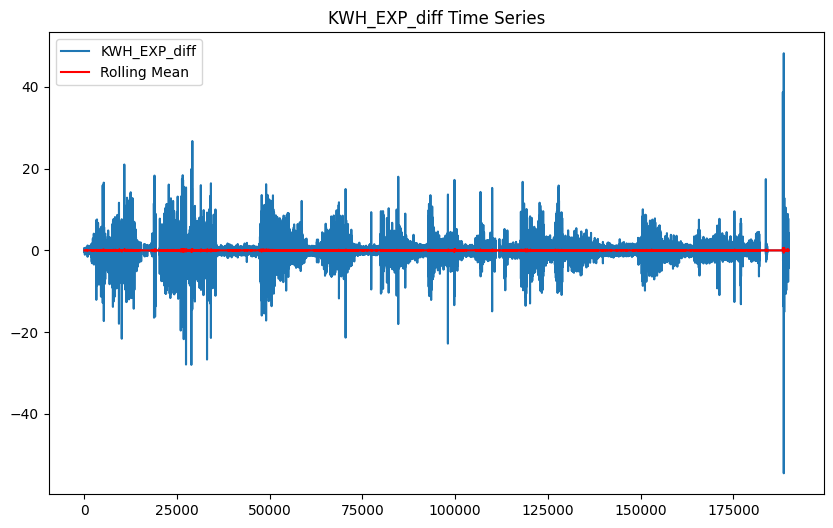

In [22]:
# moving average
rolling_mean = df['KWH_EXP_diff'].rolling(window=96).mean()

plt.figure(figsize=(10, 6))
plt.plot(df['KWH_EXP_diff'], label='KWH_EXP_diff')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.legend(loc='best')
plt.title('KWH_EXP_diff Time Series')
plt.show()


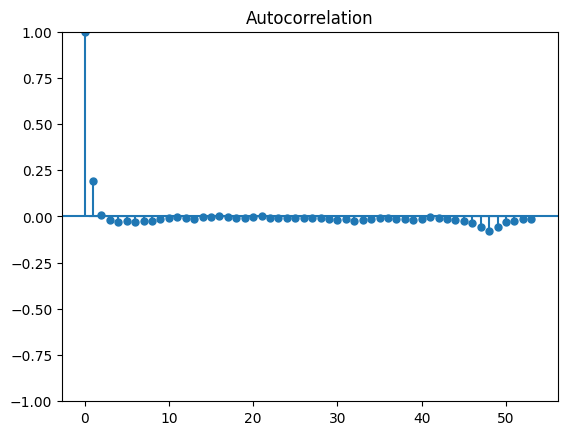

In [23]:
plot_acf(df['KWH_EXP_diff'])
plt.show()

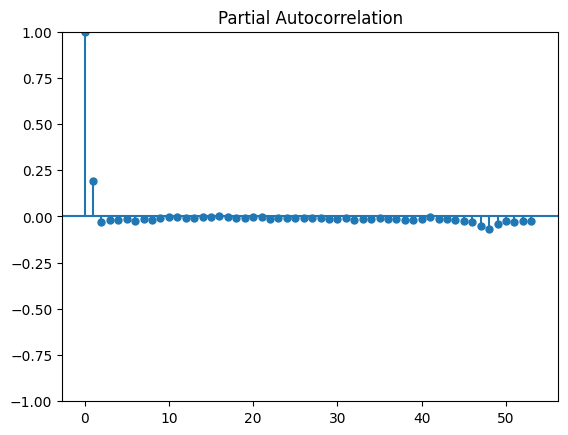

In [24]:
# plot pacf
plot_pacf(df['KWH_EXP_diff'])
plt.show()

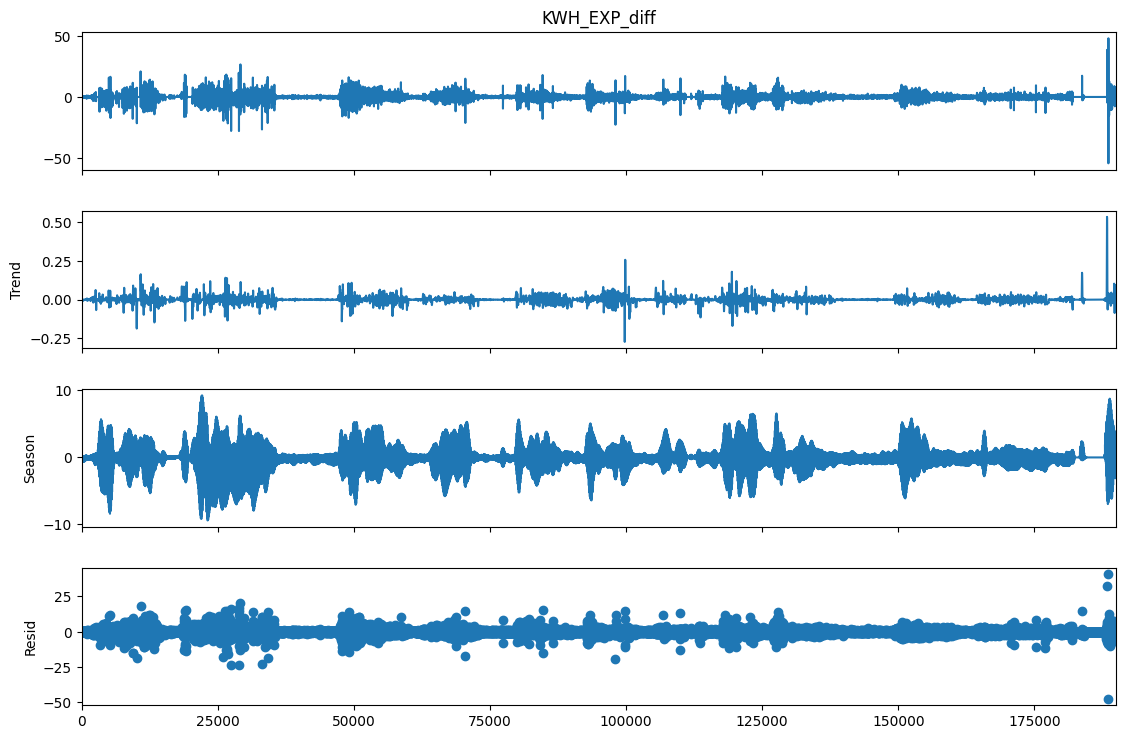

In [25]:
# plot decomposition 
stl = STL(df['KWH_EXP_diff'], seasonal=13, period=96)
res = stl.fit()

fig = res.plot()
fig.set_size_inches(12, 8)
plt.show()